# Using symmetry in the problems to make quantum computing more efficient
We can use quantum computers to help us with machine learning. By utilizing variational quantum circuits, we can use quantum computers to learn patterns in data.

In order for this to work well, we need to come up with a way to encode the patterns we want to learn into the quantum computer. Especially on near-term quantum hardware, this requires quite some resources. One way to reduce these resource requirements and learn more efficiently is to take advantage of symmetries in the data we are trying to learn.

One approach is taken in [this paper](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.010328) (CC-BY 4.0, Johannes Jakob Meyer, Marian Mularski, Elies Gil-Fuster, Antonio Anna Mele, Francesco Arzani, Alissa Wilms, and Jens Eisert) and we will use it as a guideline for this challenge. A huge thank you to the authors for providing this idea and explaing it so well :-)

# Basic code to work with the Tic-Tac-Toe example

The following code cells will provide you with some tools you can use to generate data from tic-tac-toe that you can use to train your variational quantum circuit.

The helper function generate tic-tac-toe board positions or help determine the winner.

In [2]:
# helper function to determine valid tic tac toe board positions
def get_winner(board):
        # Check the board for any winning combinations
    winning_combinations = [
        # Rows
        (0, 1, 2),
        (3, 4, 5),
        (6, 7, 8),
        # Columns
        (0, 3, 6),
        (1, 4, 7),
        (2, 5, 8),
        # Diagonals
        (0, 4, 8),
        (2, 4, 6),
    ]
    
    x_wins = False
    o_wins = False
    
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] and board[combo[0]] != '':
            if board[combo[0]] == 'x':
                return [0,0,1]
            else:
                return [1,0,0]
    return [0,1,0]
    

def is_valid_tic_tac_toe(board):
    # Check that the board has exactly 9 elements
    if len(board) != 9:
        return False
    
    # Count the number of 'x' and 'o' on the board
    count_x = board.count('x')
    count_o = board.count('o')
    
    # Check that the difference in count between 'x' and 'o' is 0 or 1
    if abs(count_x - count_o) > 1:
        return False
    
    # Check the board for any winning combinations
    winning_combinations = [
        # Rows
        (0, 1, 2),
        (3, 4, 5),
        (6, 7, 8),
        # Columns
        (0, 3, 6),
        (1, 4, 7),
        (2, 5, 8),
        # Diagonals
        (0, 4, 8),
        (2, 4, 6),
    ]
    
    x_wins = False
    o_wins = False
    
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] and board[combo[0]] != '':
            if board[combo[0]] == 'x':
                x_wins = True
            else:
                o_wins = True
    
    # Check if both 'x' and 'o' won or if neither won
    if x_wins and o_wins or (not x_wins and not o_wins):
        return False
    
    # Check that the board is a valid final board configuration
    if (x_wins and count_x != count_o + 1) or (o_wins and count_x != count_o):
        return False
    # All checks have passed, so the board is valid
    return True
  

In [3]:
def generate_tic_tac_toe_configs():
    valid_configs = []
    winners = []
    
    # Generate all possible configurations of the board
    for i in range(3**9):
        board = []
        for j in range(9):
            symbol = ''
            if i % 3 == 0:
                symbol = 'x'
            elif i % 3 == 1:
                symbol = 'o'
            board.append(symbol)
            i //= 3
        
        # Check if the configuration is valid
        if is_valid_tic_tac_toe(board):
            valid_configs.append(board)
            winners.append(get_winner(board))
    
    return valid_configs, winners

In [4]:
boards, winners = generate_tic_tac_toe_configs()
print("boards: ", boards[1:5])
print("winners: ",  winners[1:5])
print(len(boards))
print(len(winners))

boards:  [['o', 'x', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['x', 'o', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['', '', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['', 'o', '', 'o', 'o', 'x', 'x', 'x', 'x']]
winners:  [[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
942
942


## Building the circuit

Now it is time to build the circuit. For this, we will start with some basic imports. For todays challenge, we use qiskit. However, this can be also acchieved with PennyLane or Cirq.


In [5]:
import numpy as np
from qiskit import *
import pennylane as qml
import jax
import optax
import jax.numpy as jnp

### Encoding the data

The basic element needed for your first program is the QuantumCircuit. We begin by creating a `QuantumCircuit` comprised of nine qubits.

The equivariant embedding is constructed by encoding the different numerical values that represent a game via a Pauli-X rotation on separate qubits that we view in a planar grid. To distribute the three data features equidistantly, we use a multiple of 2π/3 for the rotation angle, again as shown in the second column of Fig. 3.


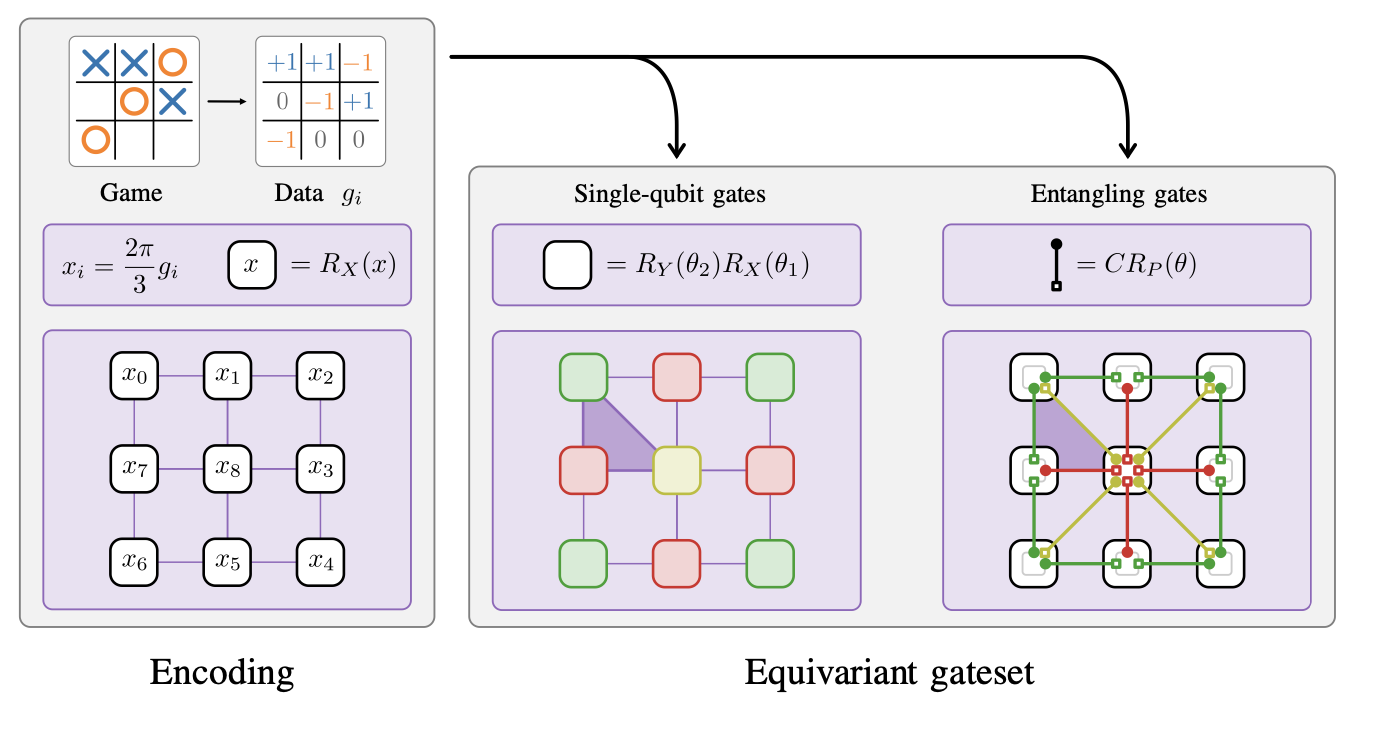

In [109]:
# tic_tac_toe_field = ['x','x','o','','o','x','o','','']
def encode_data(data_g):
    
    for entry, index in zip(data_g, range(len(data_g))):
        qml.RX(entry * 2 * np.pi / 3, wires=index)
                   

def basic_ansatz(thetas,):
    k = 0
    for lay in range(sublayers):
        basic_ansatz_layer(thetas[k:params_per_sublayer+k])
        k += params_per_sublayer

def basic_ansatz_layer(thetas):
    k=0
    for i in range(n_qubits):
        qml.RX(thetas[i], wires=i)
    k+=n_qubits
    for i in range(n_qubits):
        qml.RY(thetas[i+k], wires=i)
    k+=n_qubits
    

    corner_qubits = [0,2,6,8]
    edge_qubits = [1,3,5,7]
    center_qubit = 4
    c_e = [(0,1), (0,3), (2,1), (2,5), (6,3), (6,7), (8,5), (8,7)]
    for c, e in c_e:
        qml.CRY(thetas[k], wires=[c,e])#qui tutti thetas uguali
        k+=1
    
    #k=2n_qubits+8

    for e in edge_qubits:
        qml.CRY(thetas[k], wires=[e,center_qubit])
        k +=1
    #k=2n_qubits+8+4
    
    for c in corner_qubits:
        qml.CRY(thetas[k], wires=[center_qubit,c])

    #k=2n_qubits+8+4+4

def symmetry_output(wires):
    op_circ = qml.expval(qml.PauliZ(wires=0)@ qml.PauliZ(wires=2)@qml.PauliZ(wires=6)@ qml.PauliZ(wires=8))
    op_tie = qml.expval(qml.PauliZ(wires=4))
    op_cross = qml.expval(qml.PauliZ(wires=1)@ qml.PauliZ(wires=3)@qml.PauliZ(wires=5)@ qml.PauliZ(wires=7))
    
    return op_circ, op_tie, op_cross,  

In [110]:
n_qubits = 9
device = qml.device("default.qubit.jax", wires=n_qubits)
    
@qml.qnode(device,interface='jax')#, diff_method='adjoint') 
def circuit(x, thetas,):
    j = 0
    for lay in range(layers):
        encode_data(x)
        qml.Barrier(wires=n_qubits,only_visual=True)
        basic_ansatz(thetas[j:j+(params_per_sublayer)*sublayers],)
        j += (params_per_sublayer)*sublayers
        #symmetry_ansatz(thetas)
    qml.Barrier(wires=range(n_qubits),only_visual=True)

    # return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1)), qml.expval(qml.PauliZ(wires=2))
    return symmetry_output(wires=range(n_qubits))

# Train Non-Symmetric


Split data into test and train data

In [25]:
x = boards
y = winners

# shuffle the indices
shuffle_indices = np.random.permutation(len(x))
train_size = int(len(x) * 0.3)

# split the indices into training and testing sets
train_indices = np.array(shuffle_indices[:train_size])
test_indices = np.array(shuffle_indices[train_size:])

# create the training and testing sets
x_train, y_train = np.take(x, train_indices, axis=0), np.take(y, train_indices, axis=0)
x_test, y_test = np.take(x, test_indices, axis=0), np.take(y, test_indices, axis=0)


x_train = jnp.array(list(map(lambda x:  [1 if entry == 'x' else -1 if entry == 'o' else 0 for entry in x ], x_train)))
x_test = jnp.array(list(map(lambda x:  [1 if entry == 'x' else -1 if entry == 'o' else 0 for entry in x ], x_test)))


In [26]:
for i in range(5):
    print("Example train data: ", x_train[i], y_train[i])
    ###THERE ARE NO DRAWS!!!!!

Example train data:  [ 1  1  1  0 -1  0 -1  1 -1] [0 0 1]
Example train data:  [ 1 -1  0 -1  0 -1  1  1  1] [0 0 1]
Example train data:  [ 1  1  1  1 -1 -1  0  0 -1] [0 0 1]
Example train data:  [ 0  1  1  0  1 -1  1 -1 -1] [0 0 1]
Example train data:  [ 1  1  1 -1  0 -1 -1  1  0] [0 0 1]


(<Figure size 1900x1000 with 1 Axes>, <Axes: >)

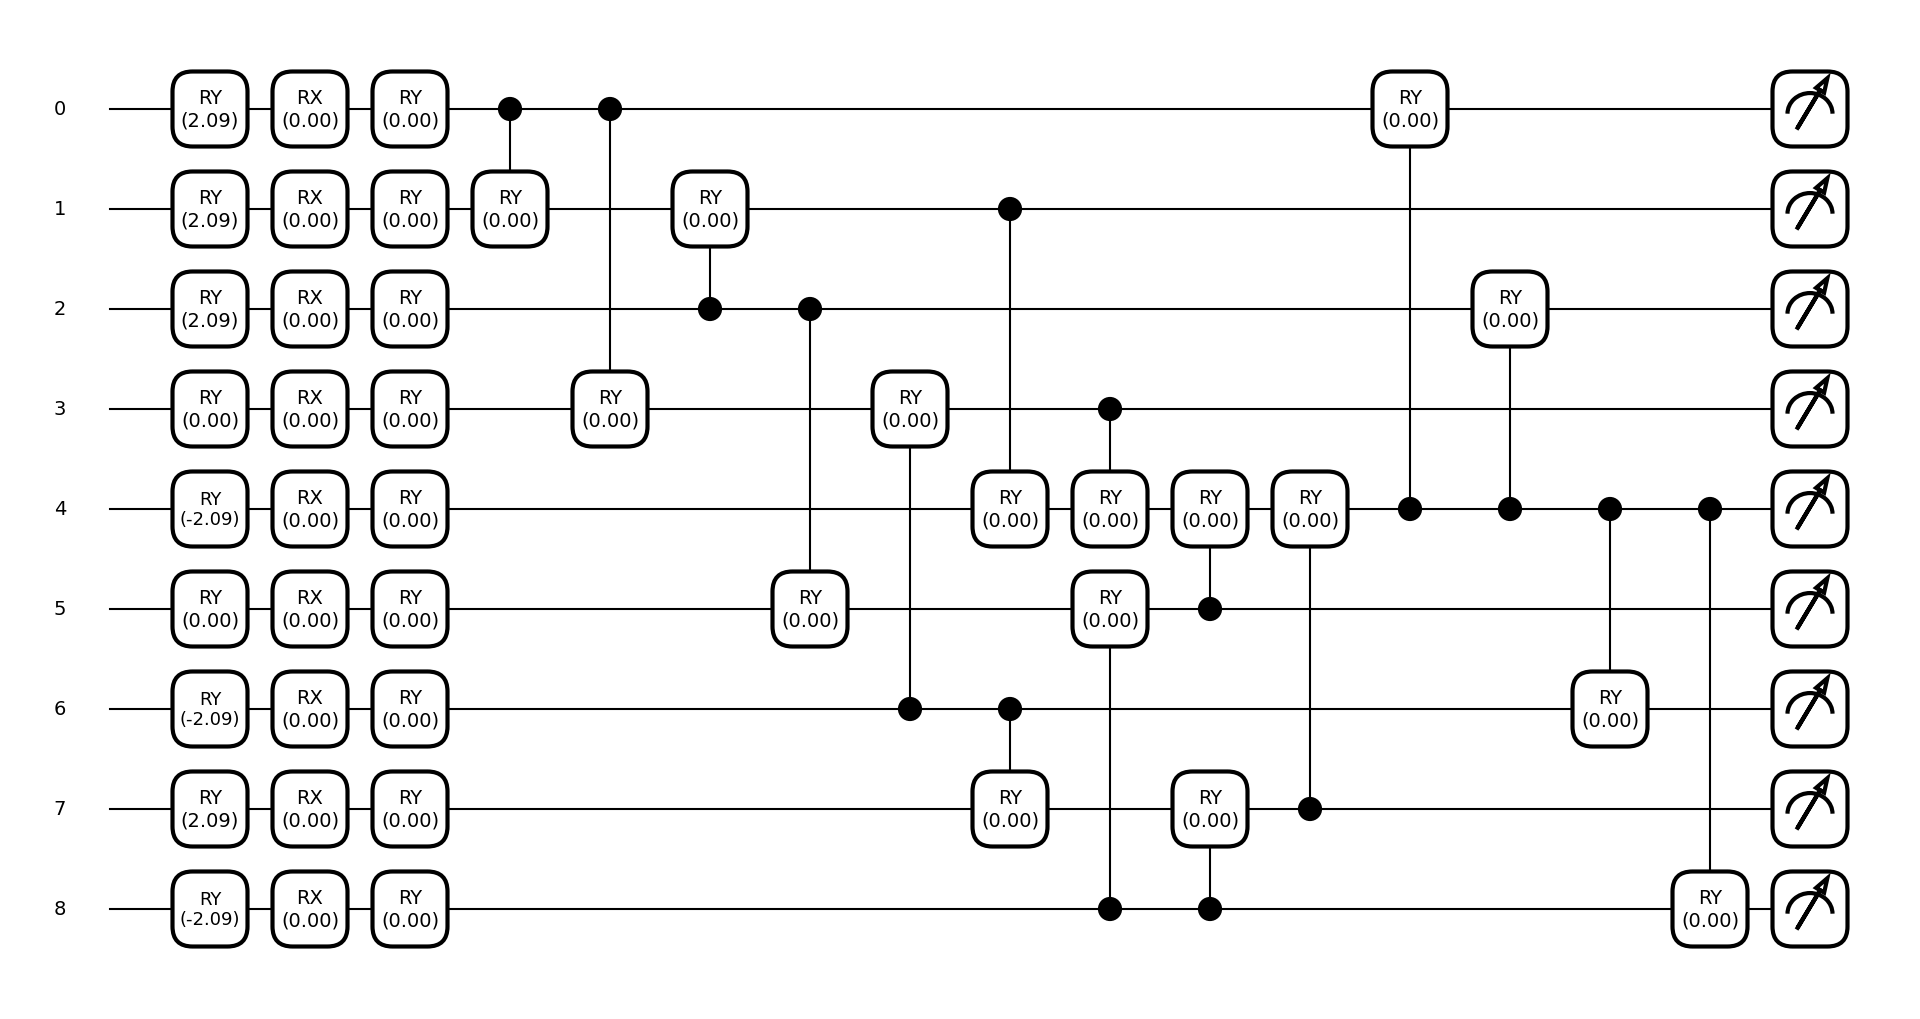

In [111]:
layers = 1
sublayers = 1
params_per_sublayer = 2*n_qubits+8+4+4
qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(x_train[0].tolist(), np.zeros((params_per_sublayer )*layers*sublayers))

In [112]:
@jax.jit
def calculate_mse_cost(X, y, theta,):
    y = jnp.array(y)
    # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # plt.show()
    yp = qnn(X, theta,) 
    yp=yp.at[:,:].multiply(.25)

    cost = jnp.mean((yp - y) ** 2)
    
    return cost

@jax.jit
def calculate_mse_cost_and_accuracy(x,y, opt_params):
    y = jnp.array(y)
    # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # plt.show()
    yp = qnn(x, opt_params,) 
    yp=yp.at[:,:].multiply(.25)

    cost = jnp.mean((yp - y) ** 2)
    max_idx_p = np.argmax(yp, axis=1)
    max_idx = np.argmax(y, axis=1)
    return cost, sum(max_idx_p==max_idx)/x.shape[0]

# Optimization update step
@jax.jit
def optimizer_update(opt_state, params, x, y, ):
    loss, grads = jax.value_and_grad(lambda theta: calculate_mse_cost(x, y, theta,))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    # print('updates------\n')
    # f=np.array(drop_rot).flatten()
    # h = optax.apply_updates(params, updates)
    # for i in zip(jnp.asarray(updates),f, params, h):
    #              print(i)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [115]:
sublayers = 1
layers = 3
params_per_sublayer = 2*n_qubits+8+4+4
qnn_batched = jax.vmap(circuit, (0, None))
qnn = jax.jit(qnn_batched)#

In [116]:
starting_seed = 123

n_runs = 1
epochs = 50
stoc_steps = 30
optimizer = optax.adam(learning_rate=0.01)
seed = 1234

costs_per_comb = []
test_costs_per_comb = []
opt_params_per_comb = []

key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=((params_per_sublayer)*layers*sublayers,))
key = jax.random.split(key)[0]

params = jnp.copy(initial_params)

opt_state = optimizer.init(initial_params)
costs = []
test_costs = []
train_accs = []
test_accs = []
print()
for epoch in range(epochs):
    for step in range(stoc_steps):
        idxs = jax.random.choice(key, jnp.array(list(range(x_train.shape[0]))), shape=(15,))
        key = jax.random.split(key)[0]

        params, opt_state, cost = optimizer_update(opt_state, params, x_train[idxs, :], y_train[idxs, :])

        cost, acc = calculate_mse_cost_and_accuracy(x_train, y_train,params)
        costs.append(cost)
        train_accs.append(acc)
        test_cost, test_acc = calculate_mse_cost_and_accuracy(x_test, y_test, params, )
        test_costs.append(test_cost)
        test_accs.append(test_acc)
     
    print(f"layers:{layers}, p:{sublayers}, epoch {epoch}/{epochs}",'--- Train cost:',cost,'--- Test cost:',test_cost, end='\r')
costs_per_comb.append(costs)
test_costs_per_comb.append(test_costs)
opt_params_per_comb.append(params)


In [50]:
import os

dir_path = '.'
data_folder_non_symm = dir_path+f'/non-symmetric/{layers}l-{sublayers}p' 
os.makedirs(data_folder_non_symm,  0o755,  exist_ok=True)
#train_cost
np.save(data_folder_non_symm+'/train_cost.npy', list(costs))
np.save(data_folder_non_symm+'/test_cost.npy', list(test_costs))
np.save(data_folder_non_symm+'/train_accs.npy', list(train_accs))
np.save(data_folder_non_symm+'/test_accs.npy', list(test_accs))
np.save(data_folder_non_symm+'/opt_params.npy', list(params))
#testcost
#train acc
#testacc
#opt params


Text(0, 0.5, 'Loss')

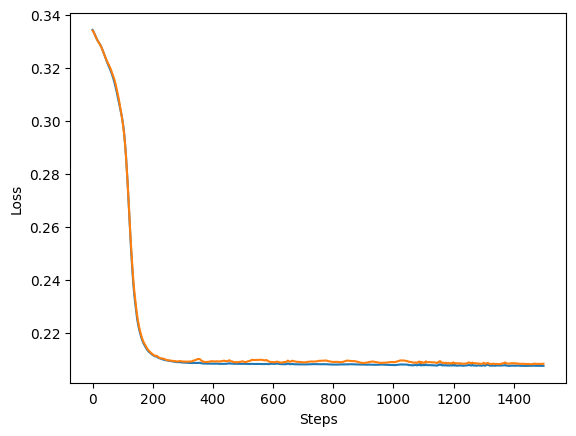

In [121]:
import matplotlib.pyplot as plt
plt.plot(costs, label='train')
plt.plot(test_costs, label='train')
plt.xlabel('Steps')
plt.ylabel('Loss')

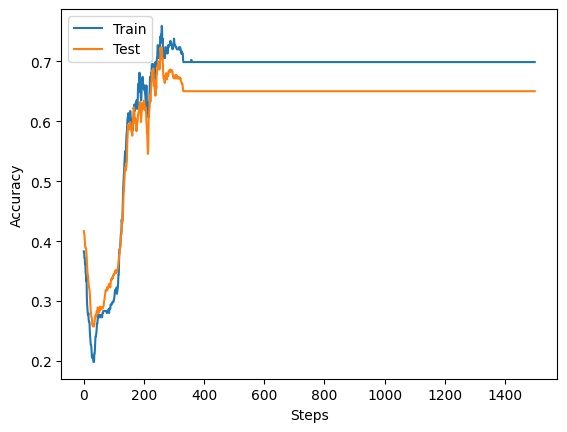

In [118]:
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

## Use the model
The final model can then be used to predict the winner for any given tic-tac-toe board.

In [40]:

def accuracy(x,y, opt_params):
    yp = qnn(x, opt_params)

    max_idx_p = np.argmax(yp, axis=1)
    max_idx = np.argmax(y, axis=1)
    
    

    return sum(max_idx_p==max_idx)/x.shape[0]
    

accuracy(x_train[:4, :], y_train[:4, :], initial_params )

[False False False False]


DeviceArray(0., dtype=float32)

In [29]:
# def predict(data, params):
#     circ = QuantumCircuit(9)
#     circ.params = params
#     encode_data(data, circ)
#     circ.barrier()
#     add_single_qubit_gates(params[0:6], circ)
#     circ.barrier()
#     add_two_qubit_gates(params[6:9], circ)

#     #TODO:  create observables and measure
#     exp_val_o = 0
#     exp_val_draw = 0
#     exp_val_x = 0

#     return [exp_val_o, exp_val_draw, exp_val_x]

# Train symmetric QNN

In [129]:
# tic_tac_toe_field = ['x','x','o','','o','x','o','','']
def encode_symm_data(data_g):
    
    for entry, index in zip(data_g, range(len(data_g))):
        qml.RX(entry * 2 * np.pi / 3, wires=index)
                   

def symmetric_ansatz(thetas,):
    k = 0
    for lay in range(sublayers):
        symmetric_ansatz_layer(thetas[k:params_per_sublayer+k])
        k += params_per_sublayer

def symmetric_ansatz_layer(thetas):
    corner_qubits = [0,2,6,8]
    edge_qubits = [1,3,5,7]
    center_qubit = 4
    
    k=0
    for c in corner_qubits:
        qml.RX(thetas[0], wires=c)
        qml.RY(thetas[1], wires=c)
    k+=2

    for e in edge_qubits:
        qml.RX(thetas[2], wires=e)
        qml.RY(thetas[3], wires=e)
    k+=2
    
    qml.RX(thetas[4], wires=center_qubit)
    qml.RY(thetas[5], wires=center_qubit)
    k+=2
    #k=6

    # it is sufficient to apply CRY only to a tringle: corner-edge-center-corner
    
    #corner center
    c_e = [(0,1), (0,3), (2,1), (2,5), (6,3), (6,7), (8,5), (8,7)]
    for c, e in c_e:
        qml.CRY(thetas[k], wires=[c,e])#qui tutti thetas uguali
    k+=1
    #k=7
    

    #edge center
    for e in edge_qubits:
        qml.CRY(thetas[k], wires=[e,center_qubit])
    k +=1
    # k=8
    
    #center corner
    for c in corner_qubits:
        qml.CRY(thetas[k], wires=[center_qubit,c])
    # k=8   
    


In [130]:
n_qubits = 9
device = qml.device("default.qubit.jax", wires=n_qubits)
    
@qml.qnode(device,interface='jax')#, diff_method='adjoint') 
def circuit_symmetric(x, thetas,):
    j = 0
    for lay in range(layers):
        encode_symm_data(x)
        qml.Barrier(wires=n_qubits,only_visual=True)
        symmetric_ansatz(thetas[j:j+(params_per_sublayer)*sublayers],)
        j += (params_per_sublayer)*sublayers
        #symmetry_ansatz(thetas)
    qml.Barrier(wires=range(n_qubits),only_visual=True)

    return symmetry_output(wires=range(n_qubits))

(<Figure size 1900x1000 with 1 Axes>, <Axes: >)

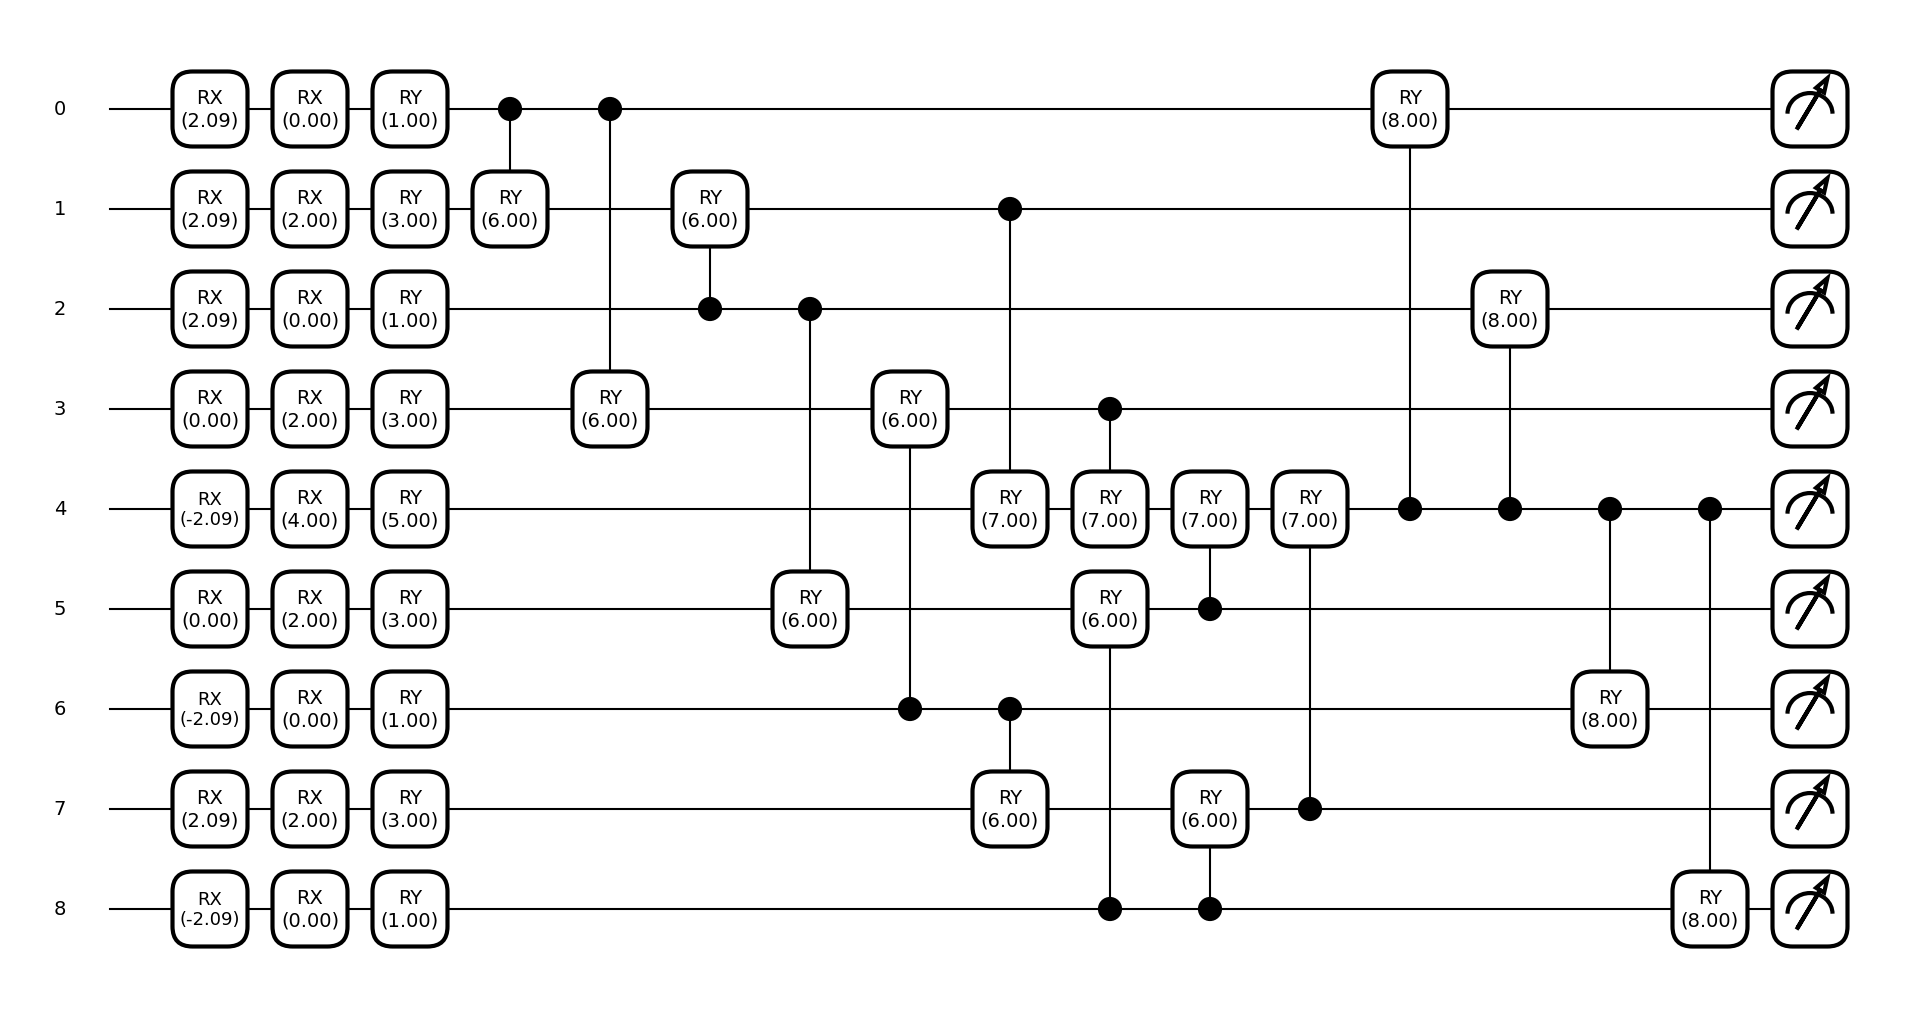

In [131]:
layers = 1
sublayers = 1
params_per_sublayer = 9
qml.draw_mpl(circuit_symmetric, decimals=2,expansion_strategy="device")(x_train[0].tolist(), np.arange((params_per_sublayer )*layers*sublayers))

In [132]:
@jax.jit
def calculate_mse_cost(X, y, theta,):
    y = jnp.array(y)
    # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # plt.show()
    yp = qnn(X, theta,) 
    yp=yp.at[:,:].multiply(.25)

    cost = jnp.mean((yp - y) ** 2)
    
    return cost

@jax.jit
def calculate_mse_cost_and_accuracy(x,y, opt_params):
    y = jnp.array(y)
    # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # plt.show()
    yp = qnn(x, opt_params,) 
    yp=yp.at[:,:].multiply(.25)

    cost = jnp.mean((yp - y) ** 2)
    max_idx_p = np.argmax(yp, axis=1)
    max_idx = np.argmax(y, axis=1)
    return cost, sum(max_idx_p==max_idx)/x.shape[0]

# Optimization update step
@jax.jit
def optimizer_update(opt_state, params, x, y, ):
    loss, grads = jax.value_and_grad(lambda theta: calculate_mse_cost(x, y, theta,))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    # print('updates------\n')
    # f=np.array(drop_rot).flatten()
    # h = optax.apply_updates(params, updates)
    # for i in zip(jnp.asarray(updates),f, params, h):
    #              print(i)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [133]:
sublayers = 1
layers = 3
params_per_sublayer = 9
qnn_batched = jax.vmap(circuit_symmetric, (0, None))
qnn = jax.jit(qnn_batched)#

In [134]:
epochs = 50
stoc_steps = 30
optimizer = optax.adam(learning_rate=0.01)
seed = 1234

costs_per_comb = []
test_costs_per_comb = []
opt_params_per_comb = []

key = jax.random.PRNGKey(seed)

initial_params = jax.random.normal(key, shape=((params_per_sublayer)*layers*sublayers,))
key = jax.random.split(key)[0]

params = jnp.copy(initial_params)

opt_state = optimizer.init(initial_params)
costs = []
test_costs = []
train_accs = []
test_accs = []
print()
for epoch in range(epochs):
    for step in range(stoc_steps):
        idxs = jax.random.choice(key, jnp.array(list(range(x_train.shape[0]))), shape=(15,))
        key = jax.random.split(key)[0]

        params, opt_state, cost = optimizer_update(opt_state, params, x_train[idxs, :], y_train[idxs, :])

        cost, acc = calculate_mse_cost_and_accuracy(x_train, y_train,params)
        costs.append(cost)
        train_accs.append(acc)
        test_cost, test_acc = calculate_mse_cost_and_accuracy(x_test, y_test, params, )
        test_costs.append(test_cost)
        test_accs.append(test_acc)
     
    print(f"layers:{layers}, p:{sublayers}, epoch {epoch}/{epochs}",'--- Train cost:',cost,'--- Test cost:',test_cost, end='\r')
costs_per_comb.append(costs)
test_costs_per_comb.append(test_costs)
opt_params_per_comb.append(params)


In [137]:
import os

dir_path = '.'
data_folder = dir_path+f'/symmetric/{layers}l-{sublayers}p'  
os.makedirs(data_folder,  0o755,  exist_ok=True)
#train_cost
np.save(data_folder+'/train_cost.npy', list(costs))
np.save(data_folder+'/test_cost.npy', list(test_costs))
np.save(data_folder+'/train_accs.npy', list(train_accs))
np.save(data_folder+'/test_accs.npy', list(test_accs))
np.save(data_folder+'/opt_params.npy', list(params))
#testcost
#train acc
#testacc
#opt params


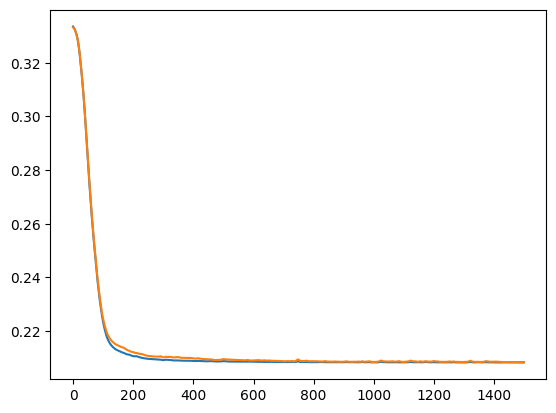

In [138]:
import matplotlib.pyplot as plt
plt.plot(costs)
plt.plot(test_costs)

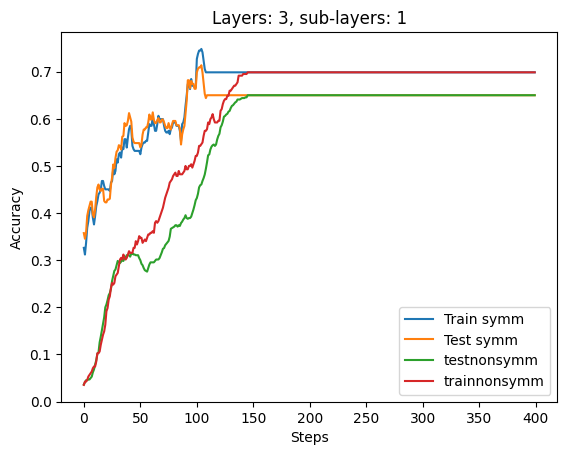

In [146]:
max_epoch = 400

plt.title(f'Layers: {layers}, sub-layers: {sublayers}')
plt.plot(train_accs[:max_epoch], label='Train symm')
plt.plot(test_accs[:max_epoch], label='Test symm')
test_accs_nonsymm =np.load(data_folder_non_symm+'/test_accs.npy', )
train_accs_nonsymm =np.load(data_folder_non_symm+'/train_accs.npy', )
plt.plot(test_accs_nonsymm[:max_epoch], label='testnonsymm')
plt.plot(train_accs_nonsymm[:max_epoch], label='trainnonsymm')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()